In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
#download dataset and store in data folder
dataset = MNIST(root='/content/drive/MyDrive/Colab Notebooks/data',train=True, download=True,transform=ToTensor())

In [5]:
print(dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()


torch.Size([1, 28, 28])
Label: 5


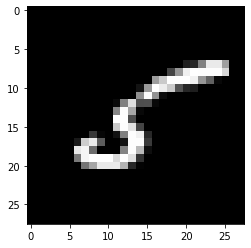

In [6]:
img, label = dataset[11]
print(img.shape)
plt.imshow(img[0], cmap='gray')
print('Label:', label)

In [7]:
#prepering the traina nd validation split
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [9]:
batch_size=128

In [10]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)# No. of subprocesses to use for data loading
val_loader=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)#If ipn_memory=True, the data loader will copy Tensors into CUDA pinned memory before returning them

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 1, 28, 28])


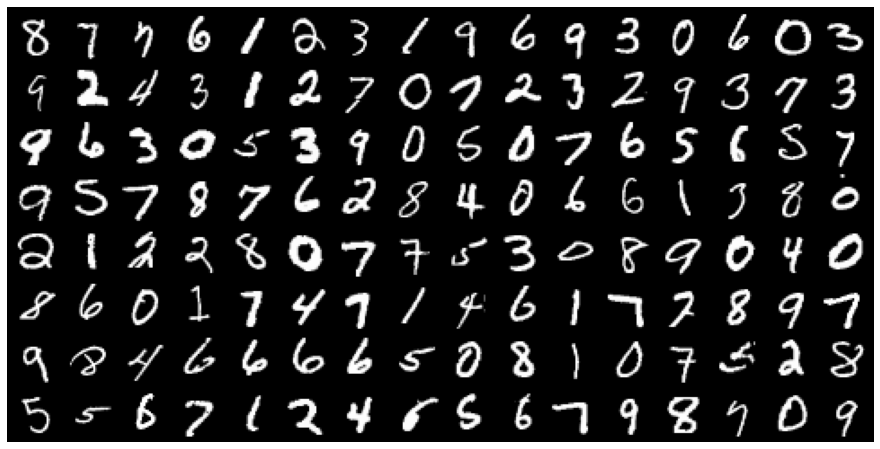

In [11]:
#visualizing batch of data using make_grid from torchvision
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [12]:
class MnistModel(nn.Module):
    
    #to create two layers
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        self.linear1=nn.Linear(in_size,hidden_size)
        self.linear2=nn.Linear(hidden_size,hidden_size)#adding more hidden layers
        self.linear3=nn.Linear(hidden_size,out_size)
    #reshaping the input features
    def forward(self,xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        #print(xb)
        # Get intermediate outputs using hidden layer
        out=self.linear1(xb)

        # Apply activation function
        out=F.relu(out)

        #get predictions using output layer
        out1=self.linear2(out) 

        out1=F.tanh(out1)

        out1=self.linear2(out1)

        return out1

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):   
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc'])) 



In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    #print(preds)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [15]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)


In [16]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [17]:
#Batsch of first 128 images passed to model
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss: 3.449354410171509
outputs.shape :  torch.Size([128, 32])
Sample outputs :
 tensor([[-0.2082,  0.0441,  0.1760, -0.1752,  0.1108,  0.1620,  0.0710,  0.1623,
         -0.0794,  0.0231, -0.1909,  0.0109,  0.0203, -0.2363,  0.1264, -0.0271,
          0.2139, -0.0753,  0.0967,  0.2132, -0.0322,  0.1188,  0.1633, -0.0553,
         -0.1074, -0.0193,  0.0141, -0.1837, -0.2006,  0.0559, -0.1777,  0.1365],
        [-0.1520,  0.0565,  0.1407, -0.0979,  0.1011,  0.2173,  0.0532,  0.1151,
         -0.0493, -0.0069, -0.1553, -0.0142,  0.0470, -0.2116,  0.0843, -0.0366,
          0.2655, -0.0287,  0.1197,  0.1996,  0.0298,  0.0874,  0.1506, -0.0913,
         -0.1035, -0.0532, -0.0306, -0.1883, -0.1359,  0.1435, -0.1109,  0.0710]])


In [18]:
torch.cuda.is_available()#checking for GPU mode

False

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
      return torch.device('cuda')
    else:
      return torch.device('cpu')  

In [20]:
device = get_default_device()
print(device)

cpu


In [21]:
#function that can move data and model to a chosen device.
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data,(list,tuple)):
       return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)   

In [22]:
for images, labels in train_loader:
    print(images.shape)
    images=to_device(images,device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cpu


In [23]:
#we define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected device.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
      self.dl=dl
      self.device=device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device) #The yield keyword in Python is used to create a generator function that can be used within a for loop.



    def __len__(self):
        """Number of batches"""
        return len(self.dl)          

In [24]:
#wrap our data loaders using DeviceDataLoader
train_loader=DeviceDataLoader(train_loader,device)
val_loader=DeviceDataLoader(val_loader,device)

In [25]:
for im,label in train_loader:
  print(im.device)
  print(label)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


cpu
tensor([9, 9, 5, 7, 8, 4, 9, 8, 1, 0, 7, 5, 9, 5, 8, 4, 3, 5, 9, 3, 1, 9, 5, 8,
        2, 0, 7, 6, 6, 8, 1, 0, 4, 2, 5, 5, 1, 4, 2, 6, 0, 2, 6, 5, 7, 9, 6, 3,
        3, 0, 7, 1, 5, 0, 7, 1, 3, 9, 6, 9, 9, 6, 1, 6, 4, 1, 6, 2, 8, 2, 7, 8,
        2, 0, 6, 6, 1, 8, 0, 5, 4, 6, 0, 4, 1, 8, 8, 5, 3, 1, 1, 3, 1, 7, 6, 9,
        0, 2, 4, 7, 6, 3, 4, 8, 9, 8, 5, 1, 1, 1, 9, 7, 1, 5, 0, 2, 5, 9, 0, 5,
        1, 5, 0, 7, 8, 7, 7, 8])


In [26]:
#Training the model
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history    

In [27]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [28]:
import time

In [29]:
GPU_time=[]
CPU_time=[]
start_time = time.time()

In [30]:
history = fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [0], val_loss: 0.2182, val_acc: 0.9324
Epoch [1], val_loss: 0.1866, val_acc: 0.9428
Epoch [2], val_loss: 0.1601, val_acc: 0.9521
Epoch [3], val_loss: 0.1471, val_acc: 0.9569
Epoch [4], val_loss: 0.1312, val_acc: 0.9597


In [54]:
print("Training time: ", round(time.time() - start_time), " seconds")
end_time=round(time.time() - start_time)

GPU_time.append(end_time)

Training time:  49  seconds


In [31]:
end_time=round(time.time() - start_time)
CPU_time.append(end_time)

In [32]:
start_time=time.time()
history+= fit(10, 0.01, model, train_loader, val_loader)
print(history)
end_time=round(time.time() - start_time)
GPU_time.append(end_time)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [0], val_loss: 0.1195, val_acc: 0.9633
Epoch [1], val_loss: 0.1170, val_acc: 0.9646
Epoch [2], val_loss: 0.1157, val_acc: 0.9647
Epoch [3], val_loss: 0.1150, val_acc: 0.9642
Epoch [4], val_loss: 0.1142, val_acc: 0.9647
Epoch [5], val_loss: 0.1138, val_acc: 0.9648
Epoch [6], val_loss: 0.1133, val_acc: 0.9647
Epoch [7], val_loss: 0.1133, val_acc: 0.9653
Epoch [8], val_loss: 0.1130, val_acc: 0.9653
Epoch [9], val_loss: 0.1128, val_acc: 0.9653
[{'val_loss': 0.2181934416294098, 'val_acc': 0.932421863079071}, {'val_loss': 0.18661203980445862, 'val_acc': 0.9427734613418579}, {'val_loss': 0.1600719839334488, 'val_acc': 0.9521484375}, {'val_loss': 0.1471235305070877, 'val_acc': 0.9569336175918579}, {'val_loss': 0.13124492764472961, 'val_acc': 0.959667980670929}, {'val_loss': 0.11950012296438217, 'val_acc': 0.9632812738418579}, {'val_loss': 0.11700405925512314, 'val_acc': 0.964648425579071}, {'val_loss': 0.11565832793712616, 'val_acc': 0.9647461175918579}, {'val_loss': 0.11495733261108398,

In [33]:
start_time=time.time()
history+= fit(15, 0.001, model, train_loader, val_loader)
print(history)
end_time=round(time.time() - start_time)
CPU_time.append(end_time)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [0], val_loss: 0.1128, val_acc: 0.9654
Epoch [1], val_loss: 0.1127, val_acc: 0.9654
Epoch [2], val_loss: 0.1127, val_acc: 0.9654
Epoch [3], val_loss: 0.1127, val_acc: 0.9654
Epoch [4], val_loss: 0.1127, val_acc: 0.9653
Epoch [5], val_loss: 0.1127, val_acc: 0.9653
Epoch [6], val_loss: 0.1127, val_acc: 0.9653
Epoch [7], val_loss: 0.1126, val_acc: 0.9653
Epoch [8], val_loss: 0.1126, val_acc: 0.9653
Epoch [9], val_loss: 0.1126, val_acc: 0.9654
Epoch [10], val_loss: 0.1126, val_acc: 0.9655
Epoch [11], val_loss: 0.1126, val_acc: 0.9654
Epoch [12], val_loss: 0.1126, val_acc: 0.9654
Epoch [13], val_loss: 0.1126, val_acc: 0.9654
Epoch [14], val_loss: 0.1126, val_acc: 0.9653
[{'val_loss': 0.2181934416294098, 'val_acc': 0.932421863079071}, {'val_loss': 0.18661203980445862, 'val_acc': 0.9427734613418579}, {'val_loss': 0.1600719839334488, 'val_acc': 0.9521484375}, {'val_loss': 0.1471235305070877, 'val_acc': 0.9569336175918579}, {'val_loss': 0.13124492764472961, 'val_acc': 0.959667980670929}, 

In [ ]:
start_time=time.time()
history+= fit(10, 0.001, model, train_loader, val_loader)
print(history)
end_time=round(time.time() - start_time)
CPU_time.append(end_time)

In [58]:
start_time=time.time()
history+= fit(15, 0.0001, model, train_loader, val_loader)
print(history)
end_time=round(time.time() - start_time)
GPU_time.append(end_time)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [0], val_loss: 0.1061, val_acc: 0.9722
Epoch [1], val_loss: 0.1061, val_acc: 0.9722
Epoch [2], val_loss: 0.1061, val_acc: 0.9722
Epoch [3], val_loss: 0.1061, val_acc: 0.9722
Epoch [4], val_loss: 0.1061, val_acc: 0.9722
Epoch [5], val_loss: 0.1061, val_acc: 0.9722
Epoch [6], val_loss: 0.1061, val_acc: 0.9722
Epoch [7], val_loss: 0.1061, val_acc: 0.9722
Epoch [8], val_loss: 0.1061, val_acc: 0.9722
Epoch [9], val_loss: 0.1061, val_acc: 0.9722
Epoch [10], val_loss: 0.1061, val_acc: 0.9722
Epoch [11], val_loss: 0.1061, val_acc: 0.9722
Epoch [12], val_loss: 0.1061, val_acc: 0.9722
Epoch [13], val_loss: 0.1061, val_acc: 0.9722
Epoch [14], val_loss: 0.1061, val_acc: 0.9722
[{'val_loss': 0.13349072635173798, 'val_acc': 0.963574230670929}, {'val_loss': 0.11936073750257492, 'val_acc': 0.9673827886581421}, {'val_loss': 0.11703585833311081, 'val_acc': 0.9697265625}, {'val_loss': 0.12864163517951965, 'val_acc': 0.96533203125}, {'val_loss': 0.1175413727760315, 'val_acc': 0.9688476324081421}, {'

In [34]:
start_time=time.time()
history+= fit(10, 0.0001, model, train_loader, val_loader)
print(history)
end_time=round(time.time() - start_time)
CPU_time.append(end_time)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [0], val_loss: 0.1126, val_acc: 0.9653
Epoch [1], val_loss: 0.1126, val_acc: 0.9653
Epoch [2], val_loss: 0.1126, val_acc: 0.9653
Epoch [3], val_loss: 0.1125, val_acc: 0.9653
Epoch [4], val_loss: 0.1125, val_acc: 0.9653
Epoch [5], val_loss: 0.1125, val_acc: 0.9653
Epoch [6], val_loss: 0.1125, val_acc: 0.9653
Epoch [7], val_loss: 0.1125, val_acc: 0.9653
Epoch [8], val_loss: 0.1125, val_acc: 0.9653
Epoch [9], val_loss: 0.1125, val_acc: 0.9653
[{'val_loss': 0.2181934416294098, 'val_acc': 0.932421863079071}, {'val_loss': 0.18661203980445862, 'val_acc': 0.9427734613418579}, {'val_loss': 0.1600719839334488, 'val_acc': 0.9521484375}, {'val_loss': 0.1471235305070877, 'val_acc': 0.9569336175918579}, {'val_loss': 0.13124492764472961, 'val_acc': 0.959667980670929}, {'val_loss': 0.11950012296438217, 'val_acc': 0.9632812738418579}, {'val_loss': 0.11700405925512314, 'val_acc': 0.964648425579071}, {'val_loss': 0.11565832793712616, 'val_acc': 0.9647461175918579}, {'val_loss': 0.11495733261108398,

In [36]:
#print(GPU_time)
GPU_time=[49, 46, 69, 68]
CPU_time=[46,88,56,89]

In [35]:
print(CPU_time)

[46, 88, 56]


In [64]:
print(type(history))
print(len(history))
epoch_list=[5,10,15,15]

<class 'list'>
45


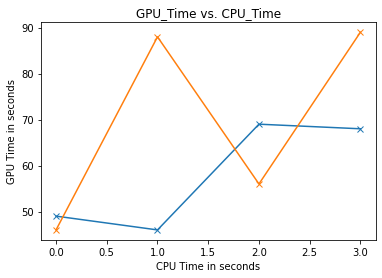

In [37]:
#plotiing GPU time based on epochs
GPU= [g for g in GPU_time]
CPU=[c for c in CPU_time]
plt.plot(GPU, '-x')
plt.plot(CPU, '-x')
plt.xlabel('CPU Time in seconds')
plt.ylabel('GPU Time in seconds')
plt.title('GPU_Time vs. CPU_Time');


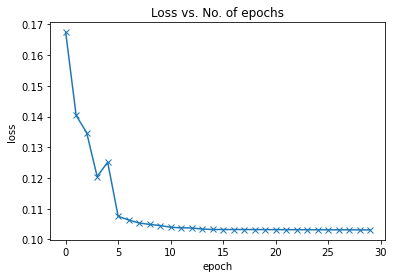

In [36]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

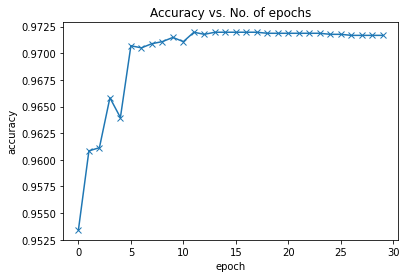

In [37]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [38]:
# Define test dataset
test_dataset = MNIST(root='/content/drive/MyDrive/Colab Notebooks/data', 
                     train=False,
                     transform=ToTensor())

In [39]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


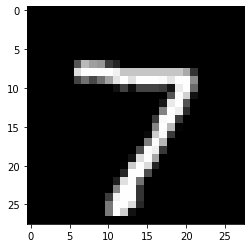

In [40]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


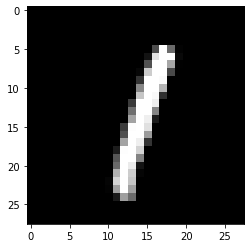

In [41]:
img, label = test_dataset[5]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


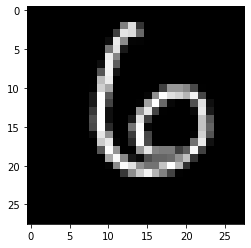

In [42]:
img, label = test_dataset[100]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [43]:
#overall loss and accuracy of test dataset
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
print(result)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


{'val_loss': 0.10312578827142715, 'val_acc': 0.9677734375}


In [44]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/data/mnist-NN_incr-GPU.pth')